In [1]:
import matplotlib.pyplot as plt
%matplotlib widget 

import numpy as np
import mne
#mne.datasets.sample.data_path()

import torch
import eegCompressModels
import imp
imp.reload(eegCompressModels)

import neptune
from neptune_pytorch import NeptuneLogger

/tmp/ipykernel_68391/4244858251.py:10: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
#raw = mne.io.read_raw_fif('./mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif')
raw = mne.io.read_raw_edf('/teamspace/uploads/ExampleLTMFiles/SVD001.edf')

Extracting EDF parameters from /teamspace/uploads/ExampleLTMFiles/SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_68391/3455569217.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('/teamspace/uploads/ExampleLTMFiles/SVD001.edf')


In [3]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~48 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [4]:
chanList = range(0,19)
nChannel = len(chanList)

data = raw.get_data()[chanList] #eeg channels
data.shape

(19, 1276416)

In [5]:
# Set in/out parameters
numSampleInput = 50
outSizeRatio = .1
inSize = nChannel * numSampleInput
outSize = int(inSize * outSizeRatio)
print(inSize, outSize)

# Construct the DataLoader
dataset = eegCompressModels.CustomDataset(data, numSampleInput)
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Make the model
encoderSizeList = [inSize, outSize, False]
decoderSizeList = [inSize, False]

model = eegCompressModels.AE(encoderSizeList, decoderSizeList)
loss_function = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1, weight_decay = 1e-8)
print(model)

950 95
AE(
  (encoder): Sequential(
    (0): Linear(in_features=950, out_features=95, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=95, out_features=950, bias=True)
    (1): ReLU()
  )
)


In [6]:
run = neptune.init_run(
    project="jettinger35/eegCompress",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjFlMzY2MS1iOWZiLTRmZWEtOGMwNy0zOTVkMTljOGVjYTMifQ==",
)

npt_logger = NeptuneLogger(
    run=run,
    model=model)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jettinger35/eegCompress/e/EEG-38


In [7]:
epochs = 1
outputs = []
losses = []

for epoch in range(epochs):
	for (image, _) in loader:
		
		# Output of Autoencoder
		reconstructed = model(image.to(torch.float32))
		
		# Calculating the loss function
		loss = loss_function(reconstructed, image)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss)
		outputs.append((epochs, image, reconstructed))
		run[npt_logger.base_namespace]["train/log_loss"].append(np.log(loss.item()))

run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 24 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 24 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/jettinger35/eegCompress/e/EEG-38/metadata


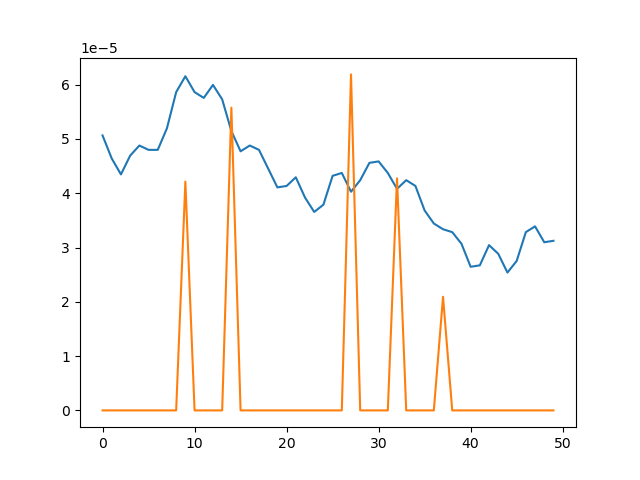

In [ ]:
#original = dataReshape[0,:]
original = data[0,0:numSampleInput]

modelInput = np.reshape(data[:, 0:numSampleInput], (inSize, -1), order='F').astype('float32').flatten()
encoded = model.encoder(torch.tensor(modelInput))
decoded = model.decoder(encoded).detach().numpy()[0: numSampleInput * nChannel: nChannel]

plt.figure()
plt.plot(original)
plt.plot(decoded)
plt.show()

### Saving the model

In [8]:
torch.save(model.state_dict(), 'savedModel')
!ls -lh

total 812K
-rwxr--r-- 1 jettinger35 jettinger35   35 Jan  7 17:09 README.md
drwxr-xr-x 1 jettinger35 jettinger35 4.0K Jan 11 20:57 __pycache__
-rwxr--r-- 1 jettinger35 jettinger35  85K Jan 11 21:18 eegCompress.ipynb
-rwxr--r-- 1 jettinger35 jettinger35 2.7K Jan 11 20:54 eegCompressModels.py
-rw-r--r-- 1 jettinger35 jettinger35 712K Jan 11 21:23 savedModel


### Misc

In [ ]:
nBlock = data.size // inSize
resizeSamples = nBlock * numSampleInput

dataReshape = np.reshape(data[:, 0:resizeSamples], (inSize, -1), order='F').transpose()
dataReshape = dataReshape.astype('float32')
dataReshape.shape

In [ ]:
# RANDOM TEST

inSize = 20
nSample = 1000000

testData = np.random.random((nSample, inSize)).astype('float32')
dataset = torch.utils.data.TensorDataset(torch.from_numpy(testData), torch.from_numpy(testData))

batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)